In [69]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, accuracy_score
from sklearn.metrics import cohen_kappa_score, precision_score, recall_score
from sklearn.externals import joblib

from imblearn.over_sampling import SMOTE, ADASYN
from scipy import sparse
import xgboost as xgb
from pathlib import Path

import re
from tqdm.auto import tqdm

from wordcloud import WordCloud
import spacy

import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
tqdm.pandas()
np.random.seed(42)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ryankingery/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
data_path = Path('..')/'data/processed'

In [3]:
def get_data(path):
    df = pd.read_csv(path/'90_day_data.csv')   
    df = df.sample(frac=1).reset_index(drop=True)   
    return df

df = get_data(data_path)
df = df.dropna()

In [4]:
def show_random_note(df):
    idx = np.random.choice(len(df))
    note = df.text.loc[idx]
    print(note)
    return note
    
note = show_random_note(df)

Admission Date:  [**2145-8-18**]       Discharge Date:  [**2145-9-6**]


Service: ACOVE

HISTORY OF PRESENT ILLNESS:  This is an 89-year-old Caucasian
female with a past medical history of depression and dementia
who was admitted on [**2145-8-18**] following an unwitnessed fall.
The patient in the emergency department was complaining of
distal radius and ulnar fracture.  She also had a right pubic
ramus fracture.  Her chest x-ray revealed a left pleural
effusion which was taped with a chest tube placed.  Chest
tubes had poor drainage.  The patient went into unexplained
respiratory arrest which required intubation.  The patient
was then sent to the Intensive Care Unit.  While in the
Intensive Care Unit the pleural effusion re-accumulated and
drainage from the chest tube.  The Intensive Care Unit team
tried to extubate the patient on four different occasions.
The first two failed due to thick secretions and hypoxia.
The third attempt at extubating failed due to a stridor that
failed to r

In [9]:
def process_text(text):
    # convert text to lowercase and strip non-ascii
    text = text.lower()
    text = text.encode("ascii", errors="ignore").decode()
    # get rid of cluttered info in top two lines
    text = re.sub(r'admission date:.*','',text)
    text = re.sub(r'date of birth:.*','',text)
    text = re.sub(r'service:.*','',text)
    # remove extra whitespace and weird ellipses (..,...)
    text = re.sub(r'\s+',' ',text)
    text = re.sub(r'[.]{2,}',' ',text)
    # replace numeric chars with <NUM> token
    text = re.sub(r'\d+','<NUM>',text)
    # remove alphanumeric characters only occuring once
    text = re.sub(r'\b\w\b','',text)
    # remove all punctuation except ',<,> and add space before '
    text = re.sub(r"[^\w\s'<>]",' ',text)
    text = re.sub("'"," '",text)
    # remove remaining extra whitespace
    text = re.sub(r'[ ]{2,}',' ',text)    
    # remove stop words
    stop_words = stopwords.words('english')
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

# %load_ext line_profiler
# %lprun -f process_text process_text(note)

# %load_ext memory_profiler
# %memit process_text(note)

df['text_processed'] = df.text.progress_apply(lambda x: process_text(x))
df.to_csv(data_path/'90_day_data_postprocessed.csv',index=False)

In [14]:
df.head(10)

,subject_id,hadm_ids,labels,text,text_processed
0,40827,160517,0,Admission Date: [**2127-12-1**] ...,cardiothoracic allergies patient recorded kno...
1,31357,132179,0,Admission Date: [**2179-8-8**] D...,neurology allergies patient recorded known al...
2,11653,130648,0,Admission Date: [**2168-5-21**] Dischar...,nb neonatology history baby girl known lastn...
3,71084,153725,0,Admission Date: [**2100-12-16**] ...,urology allergies known allergies adverse dru...
4,17642,117210,0,Admission Date: [**2143-8-14**] ...,cardiothoracic allergies amoxicillin sulfa su...
5,95004,118951 153067,0,Admission Date: [**2198-10-12**] ...,orthopaedics allergies patient recorded known...
6,7573,159990,0,Admission Date: [**2152-3-9**] Discharg...,history present illness <NUM> year old male p...
7,18623,161572 145176,0,Admission Date: [**2197-1-31**] Dischar...,admission diagnoses <NUM> coronary artery dis...
8,25367,189965,0,Admission Date: [**2153-7-28**] ...,surgery allergies penicillins attending first...
9,31784,179317,0,Admission Date: [**2136-7-26**] ...,neurosurgery allergies patient recorded known...


In [ ]:
def show_wordcloud(text):
    text = ' '.join([t for t in text])
    wordcloud = WordCloud().generate(text)
    #plt.figure(figsize=(8,8))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()
    

# print('readmit wordcloud')
# pos = df[df['labels']==1].text_processed.sample(n=1000).apply(lambda text: re.sub('NUM','',text))
# show_wordcloud(pos)

# print('non-readmit wordcloud')
# neg = df[df['labels']==0].text_processed.sample(n=1000).apply(lambda text: re.sub('NUM','',text))
# show_wordcloud(neg)

In [44]:
# nlp = spacy.load('en')
# df['text_tokenized'] = df.text_processed.progress_apply(lambda x:' '.join(t.text for t in nlp.tokenizer(x)))
# df.head()

In [49]:
cv = CountVectorizer(analyzer=str.split,ngram_range=(1,2),stop_words=None,lowercase=False,max_features=30000,max_df=0.9,min_df=1e-4)
X_counts = cv.fit_transform(df.text_processed)
print(X_counts.shape)

(53182, 30000)


In [50]:
tfidf_tr = TfidfTransformer()
X_tfidf = tfidf_tr.fit_transform(X_counts)

In [51]:
X_train,X_test,y_train,y_test = train_test_split(X_tfidf, df['labels'], test_size=0.2)
X_train_bal,y_train_bal = SMOTE().fit_sample(X_train,y_train)

In [66]:
model = RandomForestClassifier(n_estimators=100,min_samples_leaf=15,max_features='auto',min_samples_split=5,n_jobs=-1)
model.fit(X_train_bal,y_train_bal)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=15, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [67]:
def get_scores(y_train,yhat_train,y_test,yhat_test):
    print('--Training Set Scores--')
    print('accuracy: ', round(accuracy_score(y_train,yhat_train),4))
    print('precision: ', round(precision_score(y_train,yhat_train),4))
    print('recall: ', round(recall_score(y_train,yhat_train),4))
    print('f1: ', round(f1_score(y_train,yhat_train),4))
    print('auc: ', round(roc_auc_score(y_train,yhat_train),4))
    print('confusion matrix:\n', confusion_matrix(y_train,yhat_train))
    print()
    print('--Test Set Scores--')
    print('accuracy: ', round(accuracy_score(y_test,yhat_test),4))
    print('precision: ', round(precision_score(y_test,yhat_test),4))
    print('recall: ', round(recall_score(y_test,yhat_test),4))
    print('f1: ', round(f1_score(y_test,yhat_test),4))
    print('auc: ', round(roc_auc_score(y_test,yhat_test),4))
    print('confusion matrix:\n', confusion_matrix(y_test,yhat_test))

yhat_train = model.predict(X_train_bal)
yhat_test = model.predict(X_test)
get_scores(y_train_bal,yhat_train,y_test,yhat_test)

--Training Set Scores--
accuracy:  0.9111
precision:  0.9428
recall:  0.8754
f1:  0.9078
auc:  0.9111
confusion matrix:
 [[29803  1670]
 [ 3923 27550]]

--Test Set Scores--
accuracy:  0.8188
precision:  0.6884
recall:  0.5852
f1:  0.6326
auc:  0.7445
confusion matrix:
 [[7051  751]
 [1176 1659]]


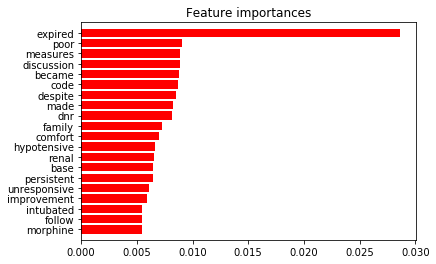

In [68]:
def plot_feature_importances(model,vectorizer,max_num=10):
    str_to_int = vectorizer.vocabulary_
    int_to_str = {val:key for key,val in str_to_int.items()}
    
    top_importances = -np.sort(-model.feature_importances_)[:max_num]
    top_importances = np.sort(top_importances)
    
    #std = np.std([tree.feature_importances_ for tree in model.estimators_],axis=0)
    
    top_features = np.argsort(-model.feature_importances_)[:max_num]
    top_words = [int_to_str[i] for i in top_features]
    top_words = reversed(top_words)
    
    plt.figure()
    plt.title('Feature importances')
    plt.barh(range(max_num), top_importances,
             color='r', align='center')
    plt.yticks(range(max_num), top_words)
    plt.ylim([-1, max_num])
    plt.show()
    
plot_feature_importances(model,cv,20)

In [85]:
model = LogisticRegression(C=0.5)
model.fit(X_train_bal,y_train_bal)

LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [86]:
yhat_train = model.predict(X_train_bal)
yhat_test = model.predict(X_test)
get_scores(y_train_bal,yhat_train,y_test,yhat_test)

--Training Set Scores--
accuracy:  0.8505
precision:  0.86
recall:  0.8374
f1:  0.8485
auc:  0.8505
confusion matrix:
 [[27184  4289]
 [ 5119 26354]]

--Test Set Scores--
accuracy:  0.8117
precision:  0.6257
recall:  0.7305
f1:  0.674
auc:  0.7859
confusion matrix:
 [[6563 1239]
 [ 764 2071]]


In [77]:
# model = xgb.XGBClassifier(n_estimators=100,n_jobs=4)
# model.fit(X_train_bal,y_train_bal)

In [ ]:
# yhat_train = model.predict(X_train_bal)
# yhat_test = model.predict(X_test)
# get_scores(y_train_bal,yhat_train,y_test,yhat_test)

In [ ]:
# plot_feature_importances(model,cv,20)

In [88]:
model.coef_.shape

(1, 30000)

9912


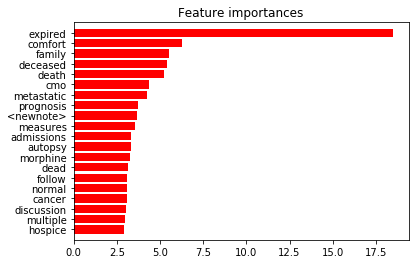

In [97]:
def plot_feature_importances(model,vectorizer,max_num=10):
    str_to_int = vectorizer.vocabulary_
    int_to_str = {val:key for key,val in str_to_int.items()}
    
    top_importances = -np.sort(-np.abs(model.coef_).flatten())[:max_num]
    top_importances = np.sort(top_importances)
    
    #std = np.std([tree.feature_importances_ for tree in model.estimators_],axis=0)
    
    top_features = np.argsort(-np.abs(model.coef_).flatten())[:max_num]
    top_words = [int_to_str[i] for i in top_features]
    top_words = reversed(top_words)
    
    plt.figure()
    plt.title('Feature importances')
    plt.barh(range(max_num), top_importances,
             color='r', align='center')
    plt.yticks(range(max_num), top_words)
    plt.ylim([-1, max_num])
    plt.show()
    
plot_feature_importances(model,cv,20)

In [ ]:
# Feature importances
features = list(X_test.columns)
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
num_features = len(importances)

# Plot the feature importances of the tree
plt.figure()
plt.title("Feature importances")
plt.bar(range(num_features), importances[indices], yerr=std[indices], 
        color="g", align="center")
plt.xticks(range(num_features), [features[i] for i in indices], rotation='45')
plt.xlim([-1, num_features])
plt.show()